In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb
import warnings

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from imblearn.over_sampling import SMOTE

warnings.filterwarnings('ignore', message='numpy.dtype size changed')

In [2]:
raw = pd.read_csv('./data/wine_vector.csv')
temp = pd.read_csv('./data/wine_vector_2.csv')
review = raw.copy(deep=True).drop(columns = ['Unnamed: 0'])
review['decription'] = temp['description']
review.head()

,country,designation,points,price,province,region_1,region_2,variety,winery,region,decription
0,0,0.0,8.111582,3.0,0,Napa Valley,Napa,0,0,0,355
1,1,1.0,8.111582,2.0,1,Toro,NaN,1,1,1,318
2,0,2.0,8.111582,1.0,0,Knights Valley,Sonoma,2,2,2,280
3,0,3.0,8.111582,1.0,2,Willamette Valley,Willamette Valley,3,3,3,386
4,2,4.0,7.111582,1.0,3,Bandol,NaN,4,4,4,376


In [3]:
srt = sorted(review['points'].unique())
print(srt)
len(srt)

[-7.888418472139406, -6.888418472139406, -5.888418472139406, -4.888418472139406, -3.8884184721394064, -2.8884184721394064, -1.8884184721394064, -0.8884184721394064, 0.1115815278605936, 1.1115815278605936, 2.1115815278605936, 3.1115815278605936, 4.111581527860594, 5.111581527860594, 6.111581527860594, 7.111581527860594, 8.111581527860594, 9.111581527860594, 10.111581527860594, 11.111581527860594, 12.111581527860595]


21

In [4]:
review.loc[(review['points'] > -8) & (review['points'] <= -4), 'points'] = 50
review.loc[(review['points'] > -4) & (review['points'] <= 0), 'points'] = 40
review.loc[(review['points'] > 0) & (review['points'] <= 4), 'points'] = 30
review.loc[(review['points'] > 4) & (review['points'] <= 8), 'points'] = 20
review.loc[(review['points'] > 8) & (review['points'] <= 13), 'points'] = 10
review.head()

,country,designation,points,price,province,region_1,region_2,variety,winery,region,decription
0,0,0.0,10.0,3.0,0,Napa Valley,Napa,0,0,0,355
1,1,1.0,10.0,2.0,1,Toro,NaN,1,1,1,318
2,0,2.0,10.0,1.0,0,Knights Valley,Sonoma,2,2,2,280
3,0,3.0,10.0,1.0,2,Willamette Valley,Willamette Valley,3,3,3,386
4,2,4.0,20.0,1.0,3,Bandol,NaN,4,4,4,376


In [5]:
review.points.unique()

array([10., 20., 30., 40., 50.])

In [6]:
# region = region_1 + region_2
review = review.drop(['region_1', 'region_2'], axis=1)
review.head()

,country,designation,points,price,province,variety,winery,region,decription
0,0,0.0,10.0,3.0,0,0,0,0,355
1,1,1.0,10.0,2.0,1,1,1,1,318
2,0,2.0,10.0,1.0,0,2,2,2,280
3,0,3.0,10.0,1.0,2,3,3,3,386
4,2,4.0,20.0,1.0,3,4,4,4,376


In [7]:
metrics = list(review.columns)
metrics.remove('points')
metrics

['country',
 'designation',
 'price',
 'province',
 'variety',
 'winery',
 'region',
 'decription']

In [8]:
# standardize data
def standardize(raw_data):
    return ((raw_data - np.mean(raw_data, axis=0)) / np.std(raw_data, axis=0))
review[metrics] = standardize(review[metrics])
review['points'] = review['points'] / 10
review.head()

,country,designation,points,price,province,variety,winery,region,decription
0,-0.763199,-0.828015,1.0,4.837673,-0.551419,-0.610443,-1.310844,-0.799095,1.684123
1,-0.264075,-0.827900,1.0,2.478687,-0.519664,-0.594970,-1.310533,-0.794537,1.146113
2,-0.763199,-0.827784,1.0,0.119702,-0.551419,-0.579498,-1.310222,-0.789978,0.593562
3,-0.763199,-0.827669,1.0,0.119702,-0.487908,-0.564026,-1.309911,-0.785420,2.134888
4,0.235049,-0.827554,2.0,0.119702,-0.456152,-0.548554,-1.309600,-0.780862,1.989480


In [9]:
features = review[metrics]
label = review['points']

smt = SMOTE(random_state=20)
    
X_train_old, X_test, Y_train_old, Y_test = train_test_split(features, label, 
                                                    test_size=0.20, 
                                                    random_state=0)
X_train, Y_train = smt.fit_sample(X_train_old, Y_train_old)
X_train = pd.DataFrame(X_train, columns=list(X_train_old.columns))
print('train/test set:', len(X_train), len(X_test))

train/test set: 195105 25174


In [10]:
# Random Forest
forest = RandomForestClassifier(n_estimators=100, 
                                random_state=0, 
                                max_depth=30, 
                                criterion='entropy')
# print('CVS:', np.mean(cross_val_score(forest, X_train, Y_train, cv=10)))
# CVS: 0.797552132025819

ACC: 0.6381981409390641
Confusion Matrix:
 [[ 122  117   25    6    3]
 [  99 2142 1016  372   61]
 [  50 1040 6088 1935  299]
 [  16  379 1880 6699  762]
 [   7   37  205  799 1015]]
Overall Report:
               precision    recall  f1-score   support

         1.0       0.41      0.45      0.43       273
         2.0       0.58      0.58      0.58      3690
         3.0       0.66      0.65      0.65      9412
         4.0       0.68      0.69      0.69      9736
         5.0       0.47      0.49      0.48      2063

   micro avg       0.64      0.64      0.64     25174
   macro avg       0.56      0.57      0.57     25174
weighted avg       0.64      0.64      0.64     25174



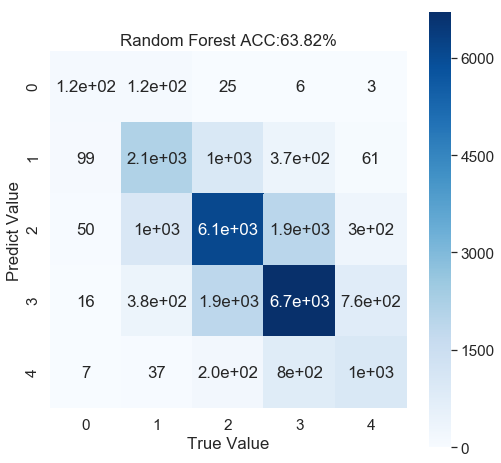

In [11]:
forest.fit(X_train, Y_train)
Y_test_predict = forest.predict(X_test)

acc = accuracy_score(Y_test, Y_test_predict)
print('ACC:', acc)
mat = confusion_matrix(Y_test, Y_test_predict)
print('Confusion Matrix:\n', mat)

plt.figure(figsize=(8, 8))
sns.set(font_scale=1.4)
sns.heatmap(mat, square=True, annot=True, cmap='Blues')
plt.xlabel('True Value')
plt.ylabel('Predict Value')
plt.title('Random Forest ACC:{0:.2f}%'.format(acc * 100))

print('Overall Report:\n', classification_report(Y_test, Y_test_predict))

Text(0.5, 1.0, 'Random Forest -- 8 Features Importance Sort')

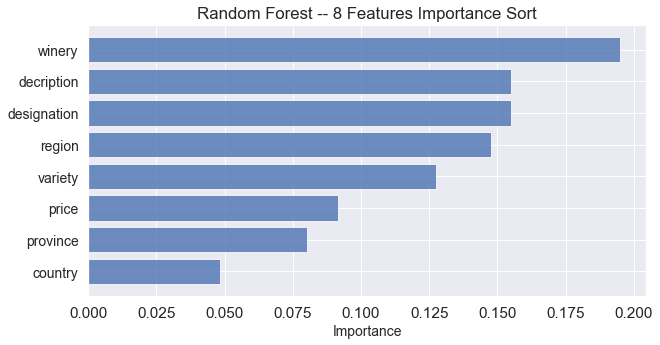

In [12]:
# Random Forest feature importance visulization
feature_names = X_train.columns
feature_imports = forest.feature_importances_
most_imp_features = pd.DataFrame([f for f in zip(feature_names, feature_imports)],
                                 columns=["Feature", "Importance"]).nlargest(len(X_train.columns), "Importance")
most_imp_features.sort_values(by="Importance", inplace=True)
plt.figure(figsize=(10, 5))
plt.barh(range(len(most_imp_features)), most_imp_features.Importance, align='center', alpha=0.8)
plt.yticks(range(len(most_imp_features)), most_imp_features.Feature, fontsize=14)
plt.xlabel('Importance', fontsize=14)
plt.title('Random Forest -- {} Features Importance Sort'.format(len(X_train.columns)))
# plt.savefig('./random-forest.jpg')

In [13]:
# XGBoost
xgb_reg = xgb.XGBClassifier(n_estimators=100, 
                           max_depth=30,
                           random_state=0)

ACC: 66.18%
Confusion Matrix:
 [[ 121  113   27    8    4]
 [  95 2185 1006  367   37]
 [  51  922 6415 1839  185]
 [  18  339 1771 6953  655]
 [   9   29  187  851  987]]
Overall Report:
               precision    recall  f1-score   support

         1.0       0.41      0.44      0.43       273
         2.0       0.61      0.59      0.60      3690
         3.0       0.68      0.68      0.68      9412
         4.0       0.69      0.71      0.70      9736
         5.0       0.53      0.48      0.50      2063

   micro avg       0.66      0.66      0.66     25174
   macro avg       0.58      0.58      0.58     25174
weighted avg       0.66      0.66      0.66     25174



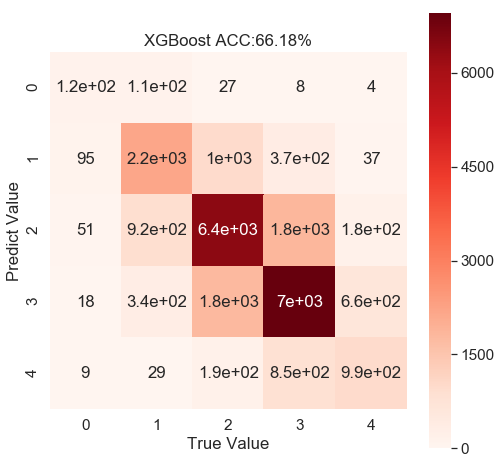

In [23]:
xgb_reg.fit(X_train, Y_train)
Y_test_predict = xgb_reg.predict(X_test)

acc = accuracy_score(Y_test, Y_test_predict)
print('ACC: %.2f' % (acc * 100) + '%')
mat = confusion_matrix(Y_test, Y_test_predict)
print('Confusion Matrix:\n', mat)

plt.figure(figsize=(8, 8))
sns.set(font_scale=1.4)
sns.heatmap(mat, square=True, annot=True, cmap='Reds')
plt.xlabel('True Value')
plt.ylabel('Predict Value')
plt.title('XGBoost ACC:{0:.2f}%'.format(acc * 100))

print('Overall Report:\n', classification_report(Y_test, Y_test_predict))

Text(0.5, 1.0, 'XGBoost -- 8 Features Importance Sort')

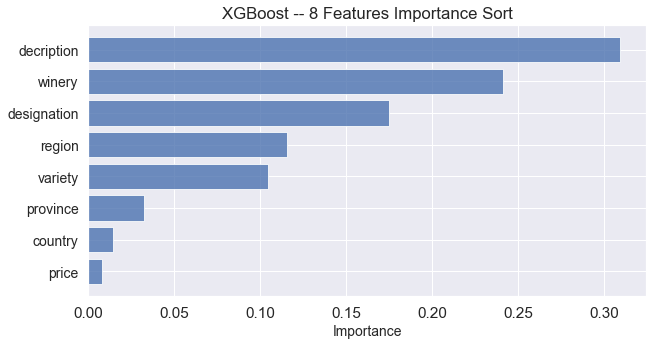

In [15]:
# XGBoost feature importance visulization
feature_names = X_train.columns
feature_imports = xgb_reg.feature_importances_
most_imp_features = pd.DataFrame([f for f in zip(feature_names, feature_imports)],
                                 columns=["Feature", "Importance"]).nlargest(len(X_train.columns), "Importance")
most_imp_features.sort_values(by="Importance", inplace=True)
plt.figure(figsize=(10, 5))
plt.barh(range(len(most_imp_features)), most_imp_features.Importance, align='center', alpha=0.8)
plt.yticks(range(len(most_imp_features)), most_imp_features.Feature, fontsize=14)
plt.xlabel('Importance', fontsize=14)
plt.title('XGBoost -- {} Features Importance Sort'.format(len(X_train.columns)))
# plt.savefig('./XGBoost.jpg')